## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Load MNIST dataset

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)

In [4]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

## Create loaders

In [7]:
train_loader = DataLoader(train_data, batch_size=6, shuffle=True)
test_loader = DataLoader(test_data, batch_size=6, shuffle=False)

In [8]:
for b, (X_train, y_train) in enumerate(train_loader):
    break
X_train.shape

torch.Size([6, 1, 28, 28])

## Create CNN class

In [9]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16,120)# 120 is arbitrary
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)

        X = X.view(-1,16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X,dim=1)

In [10]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Check amout of parameters in model

In [11]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


## Define loss func and optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
for b, (X_train, y_train) in enumerate(train_loader):
    break

In [14]:
X_train.shape

torch.Size([6, 1, 28, 28])

## Train the model

In [148]:
import time
start_time = time.time()

# Variables (trackers)
epochs = 5

train_losses = []
test_losses = []
train_correct = []
test_correct = []


# For loop epochs
for i in range(epochs):

    trn_corr = 0
    tst_corr = 0 

    # Train 
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        y_pred = model(X_train) # NOTE. No need to flatten as conv2d expect 2d data
        lossTrain = criterion(y_pred, y_train)
        #lossTrain = criterion(y_pred, y_train).data

        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum() # True 1 / False 0 
        trn_correct += batch_corr

        optimizer.zero_grad()
        lossTrain.backward()
        optimizer.step()

        if b%600 == 0:
            print(f"EPOCH {i} BATCH: {b} LOSS: {lossTrain.item()}")
    train_losses.append(lossTrain.data.item())
    train_correct.append(trn_corr)

    # Test (If we feed in test data during traing, how well will it perform)
    with torch.no_grad():
        for b,(X_test, y_test) in enumerate(test_loader):

            y_val = model(X_test)

            predicted = torch.max(y_val.data,1)[1]
            tst_corr += (predicted == y_test).sum()

        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)

current_time = time.time() 
total = current_time - start_time
print(f"Training took {total/60} minutes")

EPOCH 0 BATCH: 600 LOSS: 6.437188858399168e-06
EPOCH 0 BATCH: 1200 LOSS: 1.3709036466025282e-06
EPOCH 0 BATCH: 1800 LOSS: 0.0
EPOCH 0 BATCH: 2400 LOSS: 0.0001424194488208741
EPOCH 0 BATCH: 3000 LOSS: 4.1599341784603894e-05
EPOCH 0 BATCH: 3600 LOSS: 0.0009572989656589925
EPOCH 0 BATCH: 4200 LOSS: 0.00039790442679077387
EPOCH 0 BATCH: 4800 LOSS: 1.8019754861597903e-05
EPOCH 0 BATCH: 5400 LOSS: 1.7285257172261481e-06
EPOCH 0 BATCH: 6000 LOSS: 1.1920925402364446e-07
EPOCH 0 BATCH: 6600 LOSS: 0.0
EPOCH 0 BATCH: 7200 LOSS: 7.947284075271455e-08
EPOCH 0 BATCH: 7800 LOSS: 0.48679009079933167
EPOCH 0 BATCH: 8400 LOSS: 0.0
EPOCH 0 BATCH: 9000 LOSS: 6.35781645996758e-07
EPOCH 0 BATCH: 9600 LOSS: 0.07880112528800964
EPOCH 1 BATCH: 600 LOSS: 0.0
EPOCH 1 BATCH: 1200 LOSS: 0.00010947763803415
EPOCH 1 BATCH: 1800 LOSS: 3.4371696528978646e-06
EPOCH 1 BATCH: 2400 LOSS: 5.960463411724959e-08
EPOCH 1 BATCH: 3000 LOSS: 7.482678483938798e-05
EPOCH 1 BATCH: 3600 LOSS: 2.056282937701326e-05
EPOCH 1 BATCH: 420

## Evaluate performance

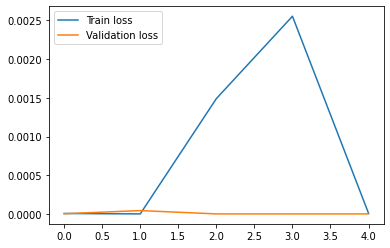

In [156]:
plt.plot(train_losses,label="Train loss")
plt.plot(test_losses, label="Validation loss")
plt.legend()

## Accuracy

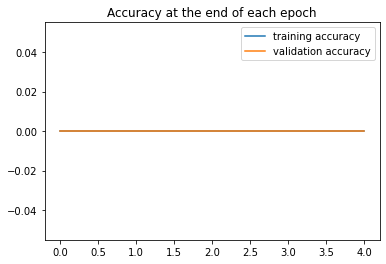

In [155]:
plt.plot([t/600 for t in train_correct], label="training accuracy")
plt.plot([t/100 for t in train_correct], label="validation accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()

In [157]:
# Här har vi ett issue. Se lect 66 i pytorch

## Evaluate all test data

In [158]:
test_load_all = DataLoader(test_data,batch_size=10000, shuffle=False)

In [159]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

In [161]:
# Accuracy for model
correct.item()/len(test_data)

0.9863

## Confusion matrix
What values is the model getting confused on. (Values on diagonal is captured correctly)

In [162]:
np.set_printoptions(formatter=dict(int=lambda x:f"{x:4}"))
print(np.arange(10).reshape(1,10))
print()

print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[ 979    0    1    1    0    2    7    0    7    0]
 [   0 1119    0    1    1    0    0    2    0    0]
 [   0    2 1024    1    0    0    2    4    3    0]
 [   0    1    0  995    0    8    0    0    1    1]
 [   0    1    1    0  969    0    1    0    0    8]
 [   0    0    0    2    0  875    6    0    3    2]
 [   0    8    0    0    4    3  942    0    0    0]
 [   1    2    6    5    0    1    0 1020    2    5]
 [   0    2    0    1    0    0    0    0  952    5]
 [   0    0    0    4    8    3    0    2    6  988]]


## Run a new image through the model

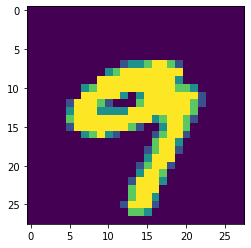

In [195]:
# Grab a random single image
n = np.random.randint(0,len(test_data))
# Plot random image
random_picture = test_data[n][0].reshape(28,28)
plt.imshow(random_picture)

In [196]:
model.eval()
with torch.no_grad():
    new_prediction = model(random_picture.view(1,1,28,28)) # 1,1,28,28 (Batchsize 1, 1, color channel, 28x28 size)
new_prediction 

tensor([[-40.9321, -63.9410, -51.0259, -55.5037, -35.1969, -51.3864, -57.9286,
         -34.2922, -48.6412,   0.0000]])

In [197]:
print(f"Model predict this is number: {new_prediction.argmax().item()}")

Model predict this is number: 9
